In [1]:
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import time
import os
from tqdm import tqdm

In [2]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# 데이터셋이 위치한 경로
# 여러분들이 다운로드 받은 데이터셋의 경로를 찍어주시면 됩니다.
data_dir = '/content/drive/MyDrive/Parrot DL Project'

In [37]:
# 이미지 변환
# 이리저리 바꿔보면서 좋은 성능이 나오도록 하시면 됩니다.
# 다만 validation은 건들지 말아주세요
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(degrees=30),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [32]:
# 여기는 건들지 말아주세요!

# 이미지 데이터셋 불러오기
full_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'),
                                          data_transforms['train'])

# 클래스명
class_names = full_dataset.classes

In [33]:
len(class_names), class_names[:10]

(200,
 ['001.Black_footed_Albatross',
  '002.Laysan_Albatross',
  '003.Sooty_Albatross',
  '004.Groove_billed_Ani',
  '005.Crested_Auklet',
  '006.Least_Auklet',
  '007.Parakeet_Auklet',
  '008.Rhinoceros_Auklet',
  '009.Brewer_Blackbird',
  '010.Red_winged_Blackbird'])

In [34]:
full_dataset[0]

(tensor([[[-1.3644, -1.2959, -1.2274,  ...,  0.2111,  0.2796,  0.3309],
          [-1.3302, -1.3130, -1.2617,  ...,  0.2111,  0.2453,  0.2796],
          [-1.2617, -1.2788, -1.2617,  ...,  0.3309,  0.3138,  0.3481],
          ...,
          [-0.9192, -0.8507, -0.7308,  ..., -0.4054, -0.3712, -0.2684],
          [-0.7650, -1.0048, -0.9877,  ..., -0.4911, -0.4739, -0.4054],
          [-0.9534, -1.0048, -1.0219,  ..., -0.5767, -0.6452, -0.6623]],
 
         [[-0.4426, -0.4601, -0.4776,  ...,  0.8704,  0.9055,  0.9055],
          [-0.4076, -0.4601, -0.4776,  ...,  0.8354,  0.8704,  0.8880],
          [-0.4426, -0.4251, -0.4426,  ...,  0.9055,  0.8880,  0.9755],
          ...,
          [-0.9153, -0.7402, -0.5826,  ...,  0.3277,  0.4153,  0.4328],
          [-0.7227, -0.8277, -0.7227,  ...,  0.1352,  0.1527,  0.1877],
          [-0.8277, -0.8627, -0.8452,  ..., -0.0049, -0.0224,  0.0126]],
 
         [[ 0.1302,  0.2348,  0.2173,  ...,  1.6291,  1.6465,  1.6640],
          [ 0.1476,  0.1825,

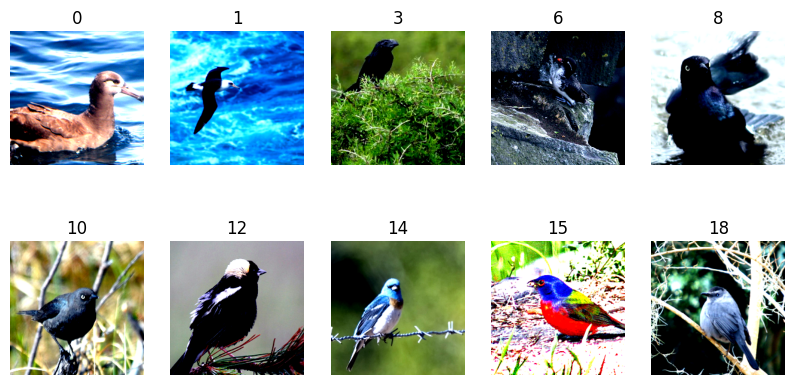

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")

plt.figure(figsize=(10,5))

cnt = 1
for i in range(0, 1000, 100):
  image, label = full_dataset[i]
  image = np.transpose(image, (1, 2, 0)) # (3, 224, 224) --> (224, 224, 3)
  image = image / 2 + 0.5  # [0, 1] 범위로 정규화

  plt.subplot(2, 5, cnt)
  plt.imshow(image)
  plt.title(label)
  plt.axis('off')
  cnt += 1

plt.show()

In [38]:
# 데이터셋을 train과 valid로 나누기
train_size = int(0.8 * len(full_dataset))
valid_size = len(full_dataset) - train_size
train_dataset, valid_dataset = random_split(full_dataset, [train_size, valid_size])

# 데이터 로더
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False, num_workers=2)

print(train_size, valid_size)
print(train_dataset[0][0].shape)

8477 2120
torch.Size([3, 224, 224])


In [39]:
# GPU 사용 가능 확인
# device(type='cuda', index=0) 가 뜬다면 GPU에서 훈련이 가능해지고 더 빨라집니다.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [11]:
!pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=b0286ad585afe36e252a4fd5c66cbb8f1b623198a894a9044baead68da929655
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [40]:
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b0', in_channels=3, num_classes=len(class_names))

Loaded pretrained weights for efficientnet-b0


In [41]:
for param in model.parameters():
    param.requires_grad = False

num_ftrs = model._fc.in_features  # EfficientNet에서는 마지막 레이어가 _fc로 되어 있다

model._fc = nn.Sequential(
    nn.Linear(num_ftrs, 2048),
    nn.SiLU(),
    nn.Dropout(0.3),
    nn.Linear(2048, len(class_names))
)

model = model.to(device)
print(model._fc)

Sequential(
  (0): Linear(in_features=1280, out_features=2048, bias=True)
  (1): SiLU()
  (2): Dropout(p=0.3, inplace=False)
  (3): Linear(in_features=2048, out_features=200, bias=True)
)


In [42]:
# 손실함수 설정
criterion = nn.CrossEntropyLoss(label_smoothing=0.2)
criterion = criterion.to(device)

# Optimizer 설정
optimizer = optim.AdamW(model._fc.parameters(), lr=0.0001)

# Scheduler 설정
step_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.75)

num_epochs=30

In [43]:
# 모델 학습과 평가
# 이 부분은 건드셔도 되고 안건드셔도 됩니다.
train_loss_list = []
train_acc_list = []
valid_loss_list = []
valid_acc_list = []

for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch+1, num_epochs))
    print('-' * 10)
    for phase in ['train', 'valid']:
        if phase == 'train':
            dataloader = train_loader
            model.train()
        else:
            dataloader = valid_loader
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in tqdm(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        if phase == 'train':
            step_lr_scheduler.step()

        epoch_loss = running_loss / len(dataloader.dataset)
        epoch_acc = running_corrects.double() / len(dataloader.dataset)
        if phase == 'train':
          train_loss_list.append(epoch_loss)
          train_acc_list.append(epoch_acc.cpu().numpy())
        else:
          valid_loss_list.append(epoch_loss)
          valid_acc_list.append(epoch_acc.cpu().numpy())


        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

print('Training complete')

Epoch 1/30
----------


100%|██████████| 133/133 [00:59<00:00,  2.24it/s]


train Loss: 5.1769 Acc: 0.1155


100%|██████████| 34/34 [00:15<00:00,  2.17it/s]


valid Loss: 4.9599 Acc: 0.3165
Epoch 2/30
----------


100%|██████████| 133/133 [01:03<00:00,  2.10it/s]


train Loss: 4.7250 Acc: 0.3423


100%|██████████| 34/34 [00:15<00:00,  2.25it/s]


valid Loss: 4.3452 Acc: 0.3792
Epoch 3/30
----------


100%|██████████| 133/133 [00:59<00:00,  2.24it/s]


train Loss: 4.0974 Acc: 0.4302


100%|██████████| 34/34 [00:14<00:00,  2.29it/s]


valid Loss: 3.7982 Acc: 0.4665
Epoch 4/30
----------


100%|██████████| 133/133 [00:57<00:00,  2.32it/s]


train Loss: 3.6303 Acc: 0.5148


100%|██████████| 34/34 [00:14<00:00,  2.30it/s]


valid Loss: 3.5062 Acc: 0.5014
Epoch 5/30
----------


100%|██████████| 133/133 [00:59<00:00,  2.25it/s]


train Loss: 3.3741 Acc: 0.5714


100%|██████████| 34/34 [00:15<00:00,  2.26it/s]


valid Loss: 3.3624 Acc: 0.5311
Epoch 6/30
----------


100%|██████████| 133/133 [00:59<00:00,  2.22it/s]


train Loss: 3.2374 Acc: 0.6025


100%|██████████| 34/34 [00:15<00:00,  2.22it/s]


valid Loss: 3.2731 Acc: 0.5594
Epoch 7/30
----------


100%|██████████| 133/133 [01:02<00:00,  2.14it/s]


train Loss: 3.1404 Acc: 0.6391


100%|██████████| 34/34 [00:15<00:00,  2.27it/s]


valid Loss: 3.2154 Acc: 0.5712
Epoch 8/30
----------


100%|██████████| 133/133 [01:00<00:00,  2.22it/s]


train Loss: 3.0622 Acc: 0.6547


100%|██████████| 34/34 [00:15<00:00,  2.27it/s]


valid Loss: 3.1596 Acc: 0.5811
Epoch 9/30
----------


100%|██████████| 133/133 [00:57<00:00,  2.29it/s]


train Loss: 2.9954 Acc: 0.6876


100%|██████████| 34/34 [00:14<00:00,  2.36it/s]


valid Loss: 3.1250 Acc: 0.5991
Epoch 10/30
----------


100%|██████████| 133/133 [00:58<00:00,  2.26it/s]


train Loss: 2.9465 Acc: 0.6941


100%|██████████| 34/34 [00:15<00:00,  2.25it/s]


valid Loss: 3.0943 Acc: 0.6028
Epoch 11/30
----------


100%|██████████| 133/133 [00:59<00:00,  2.23it/s]


train Loss: 2.9097 Acc: 0.7085


100%|██████████| 34/34 [00:15<00:00,  2.26it/s]


valid Loss: 3.0716 Acc: 0.6047
Epoch 12/30
----------


100%|██████████| 133/133 [01:00<00:00,  2.21it/s]


train Loss: 2.8742 Acc: 0.7212


100%|██████████| 34/34 [00:15<00:00,  2.23it/s]


valid Loss: 3.0554 Acc: 0.6104
Epoch 13/30
----------


100%|██████████| 133/133 [00:59<00:00,  2.22it/s]


train Loss: 2.8407 Acc: 0.7352


100%|██████████| 34/34 [00:14<00:00,  2.28it/s]


valid Loss: 3.0352 Acc: 0.6198
Epoch 14/30
----------


100%|██████████| 133/133 [00:57<00:00,  2.31it/s]


train Loss: 2.8184 Acc: 0.7433


100%|██████████| 34/34 [00:14<00:00,  2.31it/s]


valid Loss: 3.0242 Acc: 0.6222
Epoch 15/30
----------


100%|██████████| 133/133 [00:58<00:00,  2.26it/s]


train Loss: 2.7926 Acc: 0.7492


100%|██████████| 34/34 [00:15<00:00,  2.25it/s]


valid Loss: 3.0128 Acc: 0.6316
Epoch 16/30
----------


100%|██████████| 133/133 [01:02<00:00,  2.13it/s]


train Loss: 2.7795 Acc: 0.7467


100%|██████████| 34/34 [00:15<00:00,  2.26it/s]


valid Loss: 3.0001 Acc: 0.6302
Epoch 17/30
----------


100%|██████████| 133/133 [00:59<00:00,  2.23it/s]


train Loss: 2.7534 Acc: 0.7616


100%|██████████| 34/34 [00:15<00:00,  2.24it/s]


valid Loss: 2.9924 Acc: 0.6307
Epoch 18/30
----------


100%|██████████| 133/133 [00:59<00:00,  2.25it/s]


train Loss: 2.7423 Acc: 0.7621


100%|██████████| 34/34 [00:14<00:00,  2.28it/s]


valid Loss: 2.9840 Acc: 0.6358
Epoch 19/30
----------


100%|██████████| 133/133 [00:58<00:00,  2.27it/s]


train Loss: 2.7291 Acc: 0.7695


100%|██████████| 34/34 [00:14<00:00,  2.27it/s]


valid Loss: 2.9809 Acc: 0.6368
Epoch 20/30
----------


100%|██████████| 133/133 [00:58<00:00,  2.28it/s]


train Loss: 2.7147 Acc: 0.7746


100%|██████████| 34/34 [00:15<00:00,  2.26it/s]


valid Loss: 2.9735 Acc: 0.6358
Epoch 21/30
----------


100%|██████████| 133/133 [00:59<00:00,  2.22it/s]


train Loss: 2.7031 Acc: 0.7798


100%|██████████| 34/34 [00:15<00:00,  2.25it/s]


valid Loss: 2.9665 Acc: 0.6429
Epoch 22/30
----------


100%|██████████| 133/133 [00:59<00:00,  2.22it/s]


train Loss: 2.6897 Acc: 0.7891


100%|██████████| 34/34 [00:15<00:00,  2.26it/s]


valid Loss: 2.9635 Acc: 0.6434
Epoch 23/30
----------


100%|██████████| 133/133 [00:59<00:00,  2.24it/s]


train Loss: 2.6816 Acc: 0.7854


100%|██████████| 34/34 [00:14<00:00,  2.27it/s]


valid Loss: 2.9593 Acc: 0.6439
Epoch 24/30
----------


100%|██████████| 133/133 [00:58<00:00,  2.28it/s]


train Loss: 2.6791 Acc: 0.7831


100%|██████████| 34/34 [00:14<00:00,  2.31it/s]


valid Loss: 2.9540 Acc: 0.6443
Epoch 25/30
----------


100%|██████████| 133/133 [01:02<00:00,  2.11it/s]


train Loss: 2.6757 Acc: 0.7890


100%|██████████| 34/34 [00:14<00:00,  2.31it/s]


valid Loss: 2.9521 Acc: 0.6387
Epoch 26/30
----------


100%|██████████| 133/133 [00:58<00:00,  2.25it/s]


train Loss: 2.6582 Acc: 0.7950


100%|██████████| 34/34 [00:15<00:00,  2.25it/s]


valid Loss: 2.9511 Acc: 0.6439
Epoch 27/30
----------


100%|██████████| 133/133 [00:59<00:00,  2.22it/s]


train Loss: 2.6588 Acc: 0.7895


100%|██████████| 34/34 [00:15<00:00,  2.25it/s]


valid Loss: 2.9489 Acc: 0.6429
Epoch 28/30
----------


100%|██████████| 133/133 [00:59<00:00,  2.25it/s]


train Loss: 2.6483 Acc: 0.7946


100%|██████████| 34/34 [00:15<00:00,  2.24it/s]


valid Loss: 2.9449 Acc: 0.6425
Epoch 29/30
----------


100%|██████████| 133/133 [00:58<00:00,  2.27it/s]


train Loss: 2.6416 Acc: 0.7972


100%|██████████| 34/34 [00:14<00:00,  2.32it/s]


valid Loss: 2.9419 Acc: 0.6415
Epoch 30/30
----------


100%|██████████| 133/133 [00:58<00:00,  2.28it/s]


train Loss: 2.6385 Acc: 0.7945


100%|██████████| 34/34 [00:15<00:00,  2.25it/s]

valid Loss: 2.9406 Acc: 0.6448
Training complete


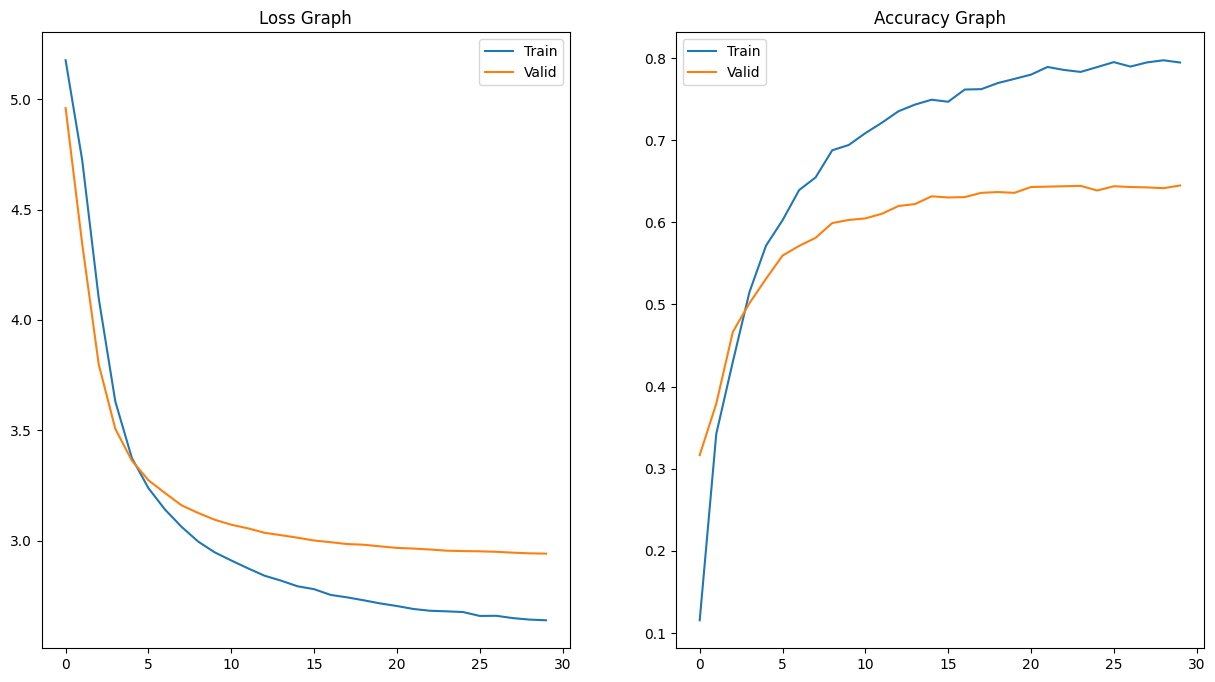

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='Train')
plt.plot(valid_loss_list, label='Valid')
plt.legend()
plt.title("Loss Graph")

plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label='Train')
plt.plot(valid_acc_list, label='Valid')
plt.title("Accuracy Graph")
plt.legend()

plt.show()

In [45]:
# 전체 모델 저장하는 부분입니다.
# PATH에는 저장할 경로를 지정해주세요
PATH = './'
torch.save(model, PATH + 'model.pt')